# Car Racing (Korean Tutorial + ResNet)

In [ ]:
!pip install swig
!pip install gymnasium[box2d]
!pip install pyglet
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376100 sha256=a0dd7f8b1fc5e76fb5ba75a18c2e54937f8fe179dbd4b316a26196e20ef2ed33
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.3/884.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_6

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

In [ ]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


(96, 96, 3)


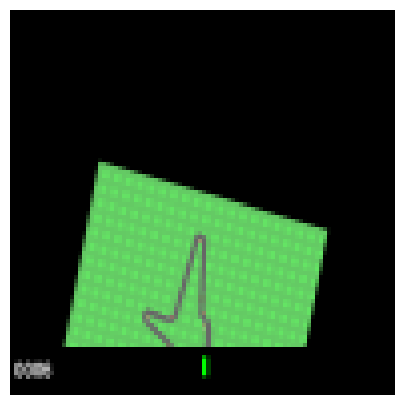

In [ ]:
s, info = env.reset()
print(s.shape)

plt.figure(figsize=(5, 5))
plt.imshow(s)
plt.axis('off')
plt.show()

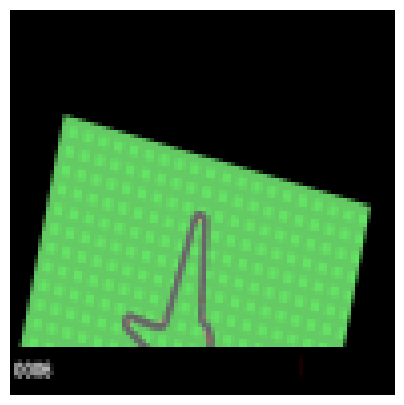

In [ ]:
# import matplotlib
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = FuncAnimation(fig, animate, frames=len(frames))
# anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

In [ ]:
import cv2
import torch

def preprocess(img):
    img = np.transpose(img, (2, 0, 1))
    # img = img[:84, 6:90] # CarRacing-v2-specific cropping
    # img = cv2.resize(img, dsize=(84, 84)) # or you can simply use rescaling

    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

In [ ]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=8,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        s_list = [s for _ in range(self.stack_frames)]
        self.stacked_state = np.stack(s_list, axis=0)
        # self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info

    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

In [ ]:
# class ImageEnv(gym.Wrapper):
#     def __init__(
#         self,
#         env,
#         skip_frames=4,
#         stack_frames=4,
#         initial_no_op=50,
#         **kwargs
#     ):
#         super(ImageEnv, self).__init__(env, **kwargs)
#         self.initial_no_op = initial_no_op
#         self.skip_frames = skip_frames
#         self.stack_frames = stack_frames

#     def reset(self):
#         # Reset the original environment.
#         s, info = self.env.reset()

#         # Do nothing for the next `self.initial_no_op` steps
#         for i in range(self.initial_no_op):
#             s, r, terminated, truncated, info = self.env.step(0)

#         # Convert a frame to 84 X 84 gray scale one
#         s = preprocess(s)
#         # The initial observation is simply a copy of the frame `s`
#         self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
#         return self.stacked_state, info

#     def step(self, action):
#         # We take an action for self.skip_frames steps
#         reward = 0
#         for _ in range(self.skip_frames):
#             s, r, terminated, truncated, info = self.env.step(action)
#             reward += r
#             if terminated or truncated:
#                 break

#         # Convert a frame to 84 X 84 gray scale one
#         s = preprocess(s)
#         # Push the current frame `s` at the end of self.stacked_state
#         self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

#         return self.stacked_state, reward, terminated, truncated, info

The shape of an observation:  (4, 3, 96, 96)


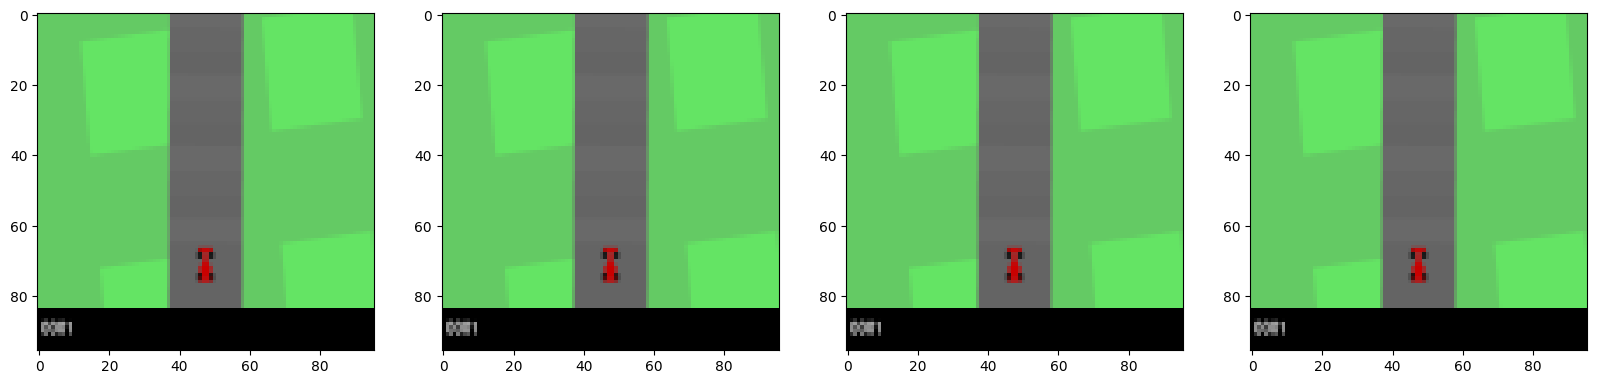

In [ ]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(np.transpose(s[i], (1, 2, 0)))
    # axes[i].imshow(s[i], cmap='gray')
    # axes[i].axis('off')
plt.show()

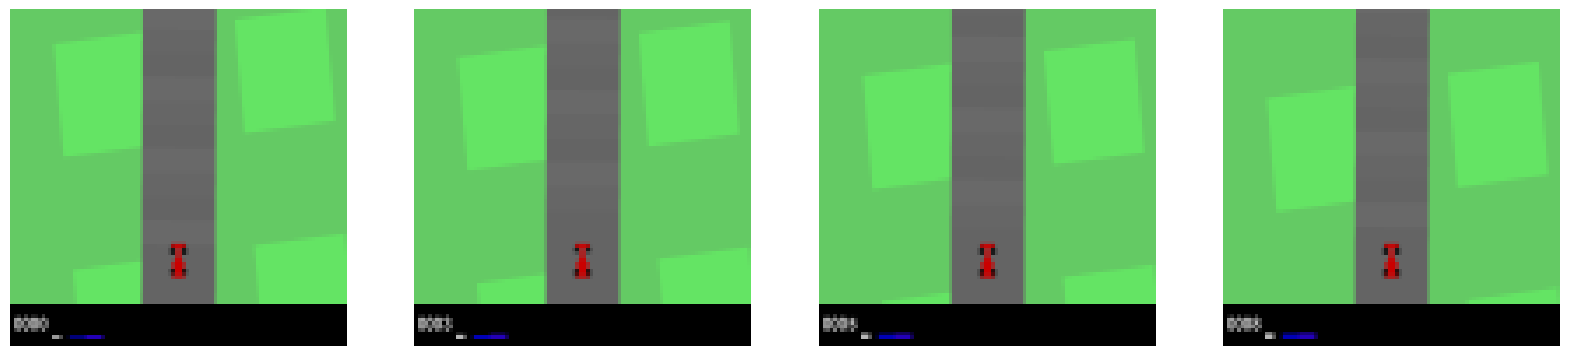

In [ ]:
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(np.transpose(s[i], (1, 2, 0)))
    # axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
class ResNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_frames):
        super(ResNetLSTM, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_dim, hidden_dim, batch_first=True) for _ in range(num_frames)])
        self.fc = nn.Linear(1024, output_dim)

    def forward(self, x):
        # x.shape: (batch_size, frames, channels, height, width)
        batch_size, frames, channels, height, width = x.size()


        # Reshape to combine batch and frames for ResNet processing
        x = x.view(-1, channels, height, width)

        # Process frames using ResNet
        features = self.resnet(x)  # Shape: (batch_size * frames, feature_dim)

        # Reshape features back to separate frames
        features = features.view(batch_size, frames, -1)  # Shape: (batch_size, frames, feature_dim)

        # Pass each frame through its corresponding LSTM layer
        lstm_outputs = []
        for i in range(frames):
            lstm_out, _ = self.lstm_layers[i](features[:, i:i+1, :])
            lstm_outputs.append(lstm_out[:, -1, :])  # Get output from the last time step

        # Concatenate outputs from all LSTM cells
        lstm_outputs = torch.cat(lstm_outputs, dim=1)  # Shape: (batch_size, frames, hidden_dim)

        # Pass through fully connected layer
        output = self.fc(lstm_outputs)  # Shape: (batch_size, frames, output_dim)

        return output

In [ ]:
class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim, activation=F.relu):
        super(CNNActionValue, self).__init__()
        self.resnet = ResNetLSTM(512, 256, 512, 8)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, action_dim)
        self.activation = activation

    def forward(self, x):
        x = self.resnet(x)
        x = x.view((-1, 512))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.s_prime[ind]),
            torch.FloatTensor(self.terminated[ind]),
        )

In [ ]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.00025,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=32,
        warmup_steps=5000,
        buffer_size=int(1e5),
        target_update_interval=10000,
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.network = CNNActionValue(state_dim[0], action_dim)
        self.target_network = CNNActionValue(state_dim[0], action_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = torch.optim.RMSprop(self.network.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.network.to(self.device)
        self.target_network.to(self.device)

        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6

    @torch.no_grad()
    def act(self, x, training=True):
        self.network.train(training)
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            q = self.network(x)
            a = torch.argmax(q).item()
        return a

    def learn(self):
        s, a, r, s_prime, terminated = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))

        next_q = self.target_network(s_prime).detach()
        td_target = r + (1. - terminated) * self.gamma * next_q.max(dim=1, keepdim=True).values
        loss = F.mse_loss(self.network(s).gather(1, a.long()), td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        result = {
            'total_steps': self.total_steps,
            'value_loss': loss.item()
        }
        return result

    def process(self, transition):
        result = {}
        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            result = self.learn()

        if self.total_steps % self.target_update_interval == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        self.epsilon -= self.epsilon_decay
        return result

In [ ]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = 1000000
eval_interval = 10000
state_dim = (4, 3, 96, 96)
action_dim = env.action_space.n

agent = DQN(state_dim, action_dim)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [ ]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)

    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

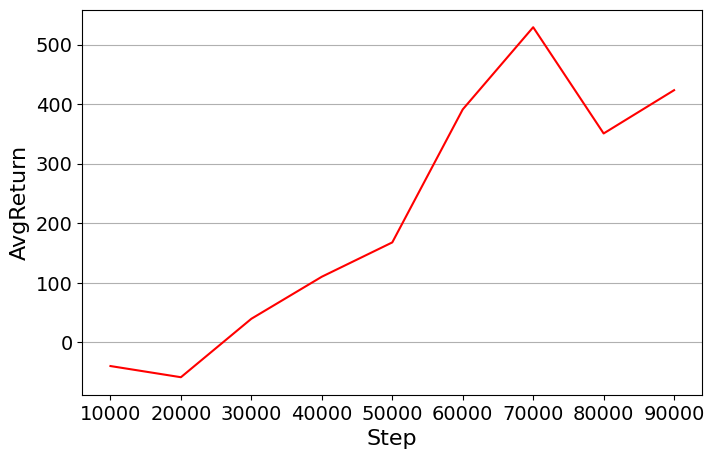

In [ ]:
from IPython.display import clear_output

history = {'Step': [], 'AvgReturn': []}

(s, _) = env.reset()
while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.

    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()

    if agent.total_steps % eval_interval == 0:
        ret = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)

        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()

        torch.save(agent.network.state_dict(), 'dqn.pt')

    if agent.total_steps > max_steps:
        break

In [ ]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

In [ ]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)